<a href="https://colab.research.google.com/github/Ksenia-90/Machine_learning-_in_business/blob/lesson_2/HW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Урок 2. #Профилирование пользователей. Сегментация аудитории: unsupervised learning (clustering, LDA/ARTM), supervised (multi/binary classification)#

### Переходим к практике

In [1]:
pip install pymorphy2

     |████████████████████████████████| 55 kB 3.1 MB/s 
     |████████████████████████████████| 8.2 MB 27.5 MB/s 


In [2]:
pip install gensim

In [3]:
pip install razdel

In [4]:
pip install nltk

In [5]:
pip install spacy

In [6]:
pip install natasha

     |████████████████████████████████| 34.4 MB 167 kB/s 
     |████████████████████████████████| 49 kB 5.0 MB/s 
     |████████████████████████████████| 41 kB 104 kB/s 
  Created wheel for intervaltree: filename=intervaltree-3.1.0-py2.py3-none-any.whl size=26119 sha256=498ab59c6f3b95015cafec89d12f6443f293c190a5e91912c19409f431e7b2ad
  Stored in directory: /root/.cache/pip/wheels/16/85/bd/1001cbb46dcfb71c2001cd7401c6fb250392f22a81ce3722f7
Successfully built intervaltree
  Attempting uninstall: intervaltree
    Found existing installation: intervaltree 2.1.0
    Uninstalling intervaltree-2.1.0:
      Successfully uninstalled intervaltree-2.1.0


In [7]:
import pandas as pd

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Наши новости

In [9]:
#news = pd.read_csv("articles.csv")
news =pd.read_csv("/content/drive/My Drive/Colab Notebooks/articles.csv")

print(news.shape)
news.head(3)

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


Загрузим пользователей и списки последних прочитанных новостей

In [10]:
users = pd.read_csv("/content/drive/My Drive/Colab Notebooks/users_articles.csv")
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


Итак, нам нужно получить векторные представления пользователей на основе прочитанным ими новостей и самих новостей

### 1. Получаем векторные представления новостей

In [11]:
#from gensim.test.utils import common_texts
from gensim.corpora.dictionary import Dictionary

In [12]:
#предобработка текстов
import re
import numpy as np
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import nltk
nltk.download('stopwords')

from razdel import tokenize # https://github.com/natasha/razdel
#!pip install razdel

import pymorphy2  # pip install pymorphy2

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [13]:
stopword_ru = stopwords.words('russian')
len(stopword_ru)

morph = pymorphy2.MorphAnalyzer()

In [14]:
with open('/content/drive/My Drive/Colab Notebooks/stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
stopword_ru += additional_stopwords
len(stopword_ru)

776

In [15]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    
    #tokens = list(tokenize(text))
    #words = [_.text for _ in tokens]
    #words = [w for w in words if w not in stopword_ru]
    
    #return " ".join(words)
    return text

cache = {}

def lemmatization(text):
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист отлемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w)>1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords=[i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [16]:
%%time
#Запускаем очистку текста. Будет долго...
news['title'] = news['title'].apply(lambda x: clean_text(x), 1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: FutureWarning: Possible nested set at position 39
  from ipykernel import kernelapp as app


CPU times: user 31.2 s, sys: 1.45 s, total: 32.6 s
Wall time: 39.2 s


In [17]:

%%time
#Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].apply(lambda x: lemmatization(x), 1)

CPU times: user 4min 31s, sys: 853 ms, total: 4min 32s
Wall time: 4min 33s


А теперь в 3 строчки обучим нашу модель

In [18]:
news['title']

0        [заместитель, председатель, правительство, рф,...
1        [матч, финал, кубок, россия, футбол, приостано...
2        [форвард, авангард, томаш, заборский, прокомме...
3        [главный, тренер, кубань, юрий, красножанин, п...
4        [решение, попечительский, совет, владивостокск...
                               ...                        
26995    [учёный, токийский, университет, морской, наук...
26996    [глава, кафедра, отечественный, история, xx, в...
26997    [американский, учёный, уточнить, возраст, расп...
26998    [последний, тропический, углеродный, цикл, чув...
26999    [жить, примерно, тыс, назад, территория, совре...
Name: title, Length: 27000, dtype: object

In [19]:
#сформируем список наших текстов, разбив еще и на пробелы
texts = [t for t in news['title'].values]

# Create a corpus from a list of texts
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

Что такое common_dictionary и как он выглядит

In [20]:
common_dictionary[10]

'ватутин'

In [21]:
common_corpus

[[(0, 5),
  (1, 2),
  (2, 1),
  (3, 2),
  (4, 1),
  (5, 1),
  (6, 1),
  (7, 1),
  (8, 1),
  (9, 1),
  (10, 1),
  (11, 1),
  (12, 1),
  (13, 1),
  (14, 1),
  (15, 1),
  (16, 4),
  (17, 1),
  (18, 1),
  (19, 4),
  (20, 1),
  (21, 1),
  (22, 3),
  (23, 1),
  (24, 1),
  (25, 1),
  (26, 1),
  (27, 1),
  (28, 1),
  (29, 2),
  (30, 1),
  (31, 1),
  (32, 1),
  (33, 1),
  (34, 1),
  (35, 1),
  (36, 1),
  (37, 1),
  (38, 1),
  (39, 1),
  (40, 1),
  (41, 1),
  (42, 1),
  (43, 1),
  (44, 1),
  (45, 2),
  (46, 1),
  (47, 2),
  (48, 1),
  (49, 1),
  (50, 1),
  (51, 1),
  (52, 1),
  (53, 1),
  (54, 1),
  (55, 1),
  (56, 1),
  (57, 1),
  (58, 3),
  (59, 1),
  (60, 1),
  (61, 1),
  (62, 1),
  (63, 1),
  (64, 1),
  (65, 1),
  (66, 1),
  (67, 3),
  (68, 1),
  (69, 1),
  (70, 1),
  (71, 3),
  (72, 1),
  (73, 1),
  (74, 1),
  (75, 1),
  (76, 1),
  (77, 1),
  (78, 1),
  (79, 1),
  (80, 1),
  (81, 1),
  (82, 1),
  (83, 1),
  (84, 1),
  (85, 1),
  (86, 1),
  (87, 1),
  (88, 1),
  (89, 3),
  (90, 2),
  (91, 1)

Все просто - это словарь наших слов

Запускаем обучение

In [22]:
from gensim.models import LdaModel

In [23]:
LdaModel

gensim.models.ldamodel.LdaModel

In [24]:
%%time
from gensim.models import LdaModel
# Train the model on the corpus.
lda = LdaModel(common_corpus, num_topics=25, id2word=common_dictionary)#, passes=10)

CPU times: user 54.9 s, sys: 26.8 s, total: 1min 21s
Wall time: 52.4 s


In [25]:
from gensim.test.utils import datapath
# Save model to disk.
temp_file = datapath("model.lda")
lda.save(temp_file)

# Load a potentially pretrained model from disk.
lda = LdaModel.load(temp_file)

Обучили модель. Теперь 2 вопроса:

1. как выглядят наши темы
2. как получить для документа вектор значений (вероятности принадлежности каждой теме)

In [26]:
# Create a new corpus, made of previously unseen documents.
other_texts = [t for t in news['title'].iloc[:3]]
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc] 

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'nnnn', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'играть', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'хороший']


[(2, 0.49556616),
 (4, 0.042429965),
 (9, 0.20852359),
 (13, 0.08458133),
 (16, 0.0860125),
 (23, 0.0643499)]

In [27]:
x=lda.show_topics(num_topics=25, num_words=7,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Only Words 
for topic,words in topics_words:
    print("topic_{}: ".format(topic)+" ".join(words))

topic_0: операция сша американский белый нефть иран солнечный
topic_1: российский сша россия правительство рост банк рынок
topic_2: всё очень жизнь хороший большой земля кровь
topic_3: путин россия пенсия медведев глава государство владимир
topic_4: млрд журнал эксперт россия исследование руб рынок
topic_5: газ квартира британский великобритания следствие дом ткань
topic_6: ракета россия запуск новый министерство европа украина
topic_7: писать алкоголь французский клиент рекомендовать перевод напиток
topic_8: рубль россия nn статья фонд область газета
topic_9: корабль экипаж море морской российский океан флот
topic_10: nn клетка катастрофа автор парламент nnn умереть
topic_11: тело женщина обнаружить житель nn древний музей
topic_12: тыс ставка рейс стоимость цена мышь виза
topic_13: исследователь млн рост смерть составить место доллар
topic_14: товар германия инвестиция восток немецкий банк теория
topic_15: украина район автомобиль нафтогаз киев порошенко пострадать
topic_16: фестивал

Очень неплохо - большинство тем вполне можно описать о чем они

Давайте напишем функцию, которая будет нам возвращать векторное представление новости

In [28]:
#text = news['title'].iloc[0]

def get_lda_vector(text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]
    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(25):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [29]:
topic_matrix = pd.DataFrame([get_lda_vector(text) for text in news['title'].values])
topic_matrix.columns = ['topic_{}'.format(i) for i in range(25)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+['topic_{}'.format(i) for i in range(25)]]
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,6,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.333484,0.000000,0.0,0.0,0.000000,0.013568,0.575722,0.0,0.000000,0.0,0.060721,0.0,0.000000,0.000000,0.0,0.000000,0.0
1,4896,0.0,0.0,0.347956,0.0,0.000000,0.0,0.000000,0.0,0.595120,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.035461,0.0,0.000000,0.0
2,4897,0.0,0.0,0.495561,0.0,0.042443,0.0,0.000000,0.0,0.000000,0.208521,0.0,0.0,0.000000,0.084592,0.000000,0.0,0.086009,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.064337,0.0
3,4898,0.0,0.0,0.413281,0.0,0.000000,0.0,0.027358,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.238939,0.124500,0.0,0.049146,0.0,0.000000,0.0,0.119608,0.018597,0.0,0.000000,0.0
4,4899,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.880840,0.000000,0.0,0.0,0.094296,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0


Прекрасно, мы получили вектора наших новостей! И даже умеем интерпретировать получившиеся темы.

Можно двигаться далее

### Следующий шаг - векторные представления пользователей

In [30]:
users.head(3)

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"


In [31]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[['topic_{}'.format(i) for i in range(25)]].values))

In [32]:
doc_dict[293622]

array([0.        , 0.        , 0.        , 0.15764007, 0.        ,
       0.        , 0.        , 0.11984839, 0.21365003, 0.09368837,
       0.        , 0.12681943, 0.01225572, 0.        , 0.        ,
       0.        , 0.13992406, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.07510391, 0.05418826])

In [72]:
user_articles_list = users['articles'].iloc[33]

def get_user_embedding(user_articles_list):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    #user_vector = np.mean(user_vector, 0)
    #user_vector = np.median(user_vector, 0)
    user_vector = np.max(user_vector, 0)
    return user_vector

In [73]:
get_user_embedding(user_articles_list)

array([0.15200822, 0.4559831 , 0.        , 0.18969133, 0.08637947,
       0.05556948, 0.09366138, 0.        , 0.40976208, 0.09822588,
       0.09527935, 0.        , 0.        , 0.13148925, 0.16343863,
       0.01058307, 0.        , 0.09120388, 0.04803155, 0.2565378 ,
       0.03028461, 0.15336452, 0.09328394, 0.35417923, 0.        ])

Интересовался новостями с топиками topic_3, topic_14 (что-то про политику и государство)

In [74]:
users['articles'].iloc[33]

'[323329, 321961, 324743, 323186, 324632, 474690]'

In [75]:
" ".join(news[news['doc_id']==323186]['title'].iloc[0])

'глава российский мид сергей лавров опровергнуть появиться сми информация якобы готовиться обмен декларация россия сша сотрудничество сфера риа новость nn читать сообщение разговаривать автор сообщение откуда автор источник какихлибо основание подобный род репортаж откуда информация появиться журналист итог встреча госсекретарь сша джон керри nn позиция изложить декларация напринимать достаточно рамка обсе рамка совет россия нато высокий уровень продекларировать всё обеспечивать неделимость безопасность никто обеспечивать безопасность счёт безопасность продолжить министр лавров москва система нато создавать проблема безопасность поэтому декларация недостаточно договариваться совместный система россия предлагать начинать путин посещать сша нужно вести речь очередной декларация гарантия проверять объективный военнотехнический критерий гарантия ненаправленность система против российский ядерный потенциал подчеркнуть глава мид газета коммерсантъ ссылаться дипломатический источник написать 

Теперь получим эмбединги для всех пользователей и проверим их качество на конкретной downstream-задаче

In [76]:
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x), 1)])
user_embeddings.columns = ['topic_{}'.format(i) for i in range(25)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+['topic_{}'.format(i) for i in range(25)]]
user_embeddings.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24
0,u105138,0.068039,0.242946,0.000000,0.157640,0.114338,0.019988,0.000000,0.303131,0.439584,0.093688,0.176025,0.126819,0.036686,0.167409,0.000000,0.162707,0.232654,0.014344,0.127985,0.028818,0.331977,0.058551,0.035987,0.291038,0.054188
1,u108690,0.167430,0.208002,0.081427,0.324543,0.064408,0.014661,0.252369,0.016064,0.448100,0.020969,0.070484,0.026971,0.053681,0.062438,0.000000,0.219355,0.000000,0.303772,0.027782,0.000000,0.123654,0.072348,0.030117,0.191902,0.016415
2,u108339,0.224149,0.152473,0.013473,0.077349,0.094566,0.088356,0.047634,0.000000,0.392976,0.000000,0.308851,0.100948,0.069054,0.031409,0.031493,0.041407,0.000000,0.023589,0.095142,0.211619,0.025471,0.177044,0.037875,0.229522,0.020977


Датасет готов - можно попробовать обучить модель. Загрузим нашу разметку

In [77]:
target = pd.read_csv("/content/drive/My Drive/Colab Notebooks/users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [78]:
X = pd.merge(user_embeddings, target, 'left')
X.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,topic_20,topic_21,topic_22,topic_23,topic_24,churn
0,u105138,0.068039,0.242946,0.000000,0.157640,0.114338,0.019988,0.000000,0.303131,0.439584,0.093688,0.176025,0.126819,0.036686,0.167409,0.000000,0.162707,0.232654,0.014344,0.127985,0.028818,0.331977,0.058551,0.035987,0.291038,0.054188,0
1,u108690,0.167430,0.208002,0.081427,0.324543,0.064408,0.014661,0.252369,0.016064,0.448100,0.020969,0.070484,0.026971,0.053681,0.062438,0.000000,0.219355,0.000000,0.303772,0.027782,0.000000,0.123654,0.072348,0.030117,0.191902,0.016415,1
2,u108339,0.224149,0.152473,0.013473,0.077349,0.094566,0.088356,0.047634,0.000000,0.392976,0.000000,0.308851,0.100948,0.069054,0.031409,0.031493,0.041407,0.000000,0.023589,0.095142,0.211619,0.025471,0.177044,0.037875,0.229522,0.020977,1


In [79]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [80]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(X[['topic_{}'.format(i) for i in range(6)]], 
                                                    X['churn'], random_state=0)

In [81]:
logreg = LogisticRegression()
#обучим 
logreg.fit(X_train, y_train)

LogisticRegression()

In [82]:
#наши прогнозы для тестовой выборки
preds = logreg.predict_proba(X_test)[:, 1]
preds[:10]

array([0.16959152, 0.29820396, 0.20319953, 0.06158006, 0.11502231,
       0.10312794, 0.10649358, 0.12160379, 0.19427828, 0.17674085])

In [83]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

### Рассчитаем Precision, Recall, F_score

In [84]:
import itertools

In [85]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.379670, F-Score=nan, Precision=0.000, Recall=0.000


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


In [86]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1749    6]
 [ 245    0]]


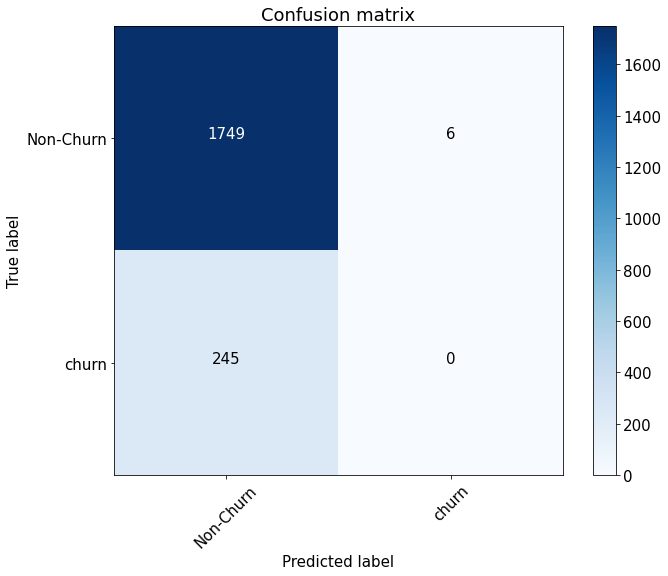

In [87]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [88]:
roc_auc_score(y_test, preds)

0.7540531426245711

В целом мы видим, что получившиеся векторные представления содержат какой-то сигнал и позволяют решать нашу прикладную задачу. 

### Домашнее задание

1. Самостоятельно разобраться с тем, что такое tfidf (документация https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html и еще - https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction)
2. Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог с помощью precision_recall_curve, как это делалось на уроке)
3. Повторить п.2, но используя уже не медиану, а max
4. (опциональное, если очень хочется) Воспользовавшись полученными знаниями из п.1, повторить пункт 2, но уже взвешивая новости по tfidf (подсказка: нужно получить веса-коэффициенты для каждого документа. Не все документы одинаково информативны и несут какой-то положительный сигнал). Подсказка 2 - нужен именно idf, как вес.
5. Сформировать на выходе единую таблицу, сравнивающую качество 3 разных метода получения эмбедингов пользователей: mean, median, max, idf_mean по метрикам roc_auc, precision, recall, f_score
6. Сделать самостоятельные выводы и предположения о том, почему тот или ной способ оказался эффективнее остальных

* через mean: Best Threshold=0.233082, F-Score=nan, Precision=0.000, Recall=0.000, roc_auc_score = 0.7044409558695274
* через median:Best Threshold=0.288052, F-Score=nan, Precision=0.000, Recall=0.000, roc_auc_score = 0.7553532182103609
* через max: Best Threshold=0.379670, F-Score=nan, Precision=0.000, Recall=0.000, roc_auc_score = 0.7540531426245711

precision_recall_curve выбирает несколько пороговых значений, которые слишком высоки для данных, поэтому мы получили точки, где оба precision и recall равны нулю. Это приводит к nan в показателе F-Score. Чтобы получить более точные выводы, можно например использовать np.divide (если знаменатель не равен нулю).